In [34]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.plotting import plot_cumulative_returns_by_quantile
from alphalens.performance import mean_return_by_quantile
from alphalens.performance import factor_information_coefficient
from alphalens.plotting import plot_quantile_returns_violin
from alphalens.plotting import plot_ic_ts

In [2]:
# GLOBAL SETTINGS

# Directories
model_dataDir = 'DATA/MODELDATA/'
model_plot_dataDir = 'DATA/MODELRESULTS/'

# Time
START = 2020
END = 2022



#Helpers
idx = pd.IndexSlice



In [3]:
# Helper Functions
def get_trade_prices(start, stop):
    model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
    model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
    model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
    model_mdf.set_index(['Dates', 'Coin'], inplace=True)
    model_mdf = model_mdf.loc[:,'Open']
    #model_mdf = model_mdf.loc[idx[Coin, str(START):str(END)], 'Open']
    prices = model_mdf.unstack('Coin').sort_index().shift(-1).tz_localize('UTC')
    
    return prices



def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()


def get_factor(predictions):
    return (predictions.unstack('Coin')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='Dates')
            .sort_index())    

In [4]:
# Load the Model Results Data
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
ridge_scores = pd.read_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')
lasso_scores = pd.read_hdf(f'{model_dataDir}Lasso_Scores.h5', 'lasso/scores')
lasso_predictions = pd.read_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')

# Load the OHLV Price data
#model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
#model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
#model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
#model_mdf.set_index(['Dates', 'Coin'], inplace=True)
#model_mdf = model_mdf.loc[:,'Open':'Volume']
#prices = model_mdf.unstack('Coin').sort_index().shift(-1).tz_localize('UTC')

In [5]:
# Now we will check the Alpha and Beta metrics of the signals found by our models in the prior step

In [6]:
# From Linear Regression
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

Dates                      Coin                 
2020-03-04 00:00:00+00:00  basic-attention-token    0.023073
                           binancecoin              0.020052
                           bitcoin                  0.018368
                           bitcoin-cash             0.019850
                           bitcoin-cash-sv          0.028136
dtype: float64

In [7]:
trade_prices = get_trade_prices(START, END)
#trade_prices.info()

In [8]:
#trade_prices = trade_prices.loc['2021':]
trade_prices = trade_prices.loc[str(START):]

In [9]:
trade_prices.head()

Coin,basic-attention-token,binancecoin,bitcoin,bitcoin-cash,bitcoin-cash-sv,bittorrent-old,cardano,celsius-degree-token,chainlink,cosmos,...,nexo,okb,quant-network,ripple,stellar,tezos,theta-token,tron,vechain,zcash
Dates,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,0.190072,13.522027,7139.044338,201.799270,95.251893,0.000280,0.032875,0.144954,1.784257,4.283589,...,0.098608,2.583228,3.676315,0.191127,0.044894,1.351242,0.085440,0.013090,0.005313,27.657228
2020-01-02 00:00:00+00:00,0.185653,13.579740,7196.883716,203.727639,96.466791,0.000283,0.033663,0.142405,1.780386,4.169424,...,0.104460,2.612412,3.563887,0.190122,0.045167,1.272692,0.085352,0.013154,0.005259,27.393856
2020-01-03 00:00:00+00:00,0.186281,13.650140,7320.309525,221.811173,104.624500,0.000289,0.033864,0.143119,1.791668,4.291417,...,0.111532,2.619287,3.577465,0.192036,0.045401,1.277193,0.088620,0.013391,0.005350,28.276526
2020-01-04 00:00:00+00:00,0.190017,13.972162,7448.688305,223.863172,110.612056,0.000290,0.034543,0.147809,1.804323,4.318510,...,0.112467,2.678726,3.442062,0.194730,0.045771,1.268082,0.092812,0.013656,0.005580,30.396363
2020-01-05 00:00:00+00:00,0.191317,14.380112,7520.122401,236.732977,115.716651,0.000296,0.035271,0.144976,1.838128,4.193687,...,0.116590,2.711035,3.637298,0.196440,0.046401,1.268031,0.099747,0.013867,0.005519,31.452828


In [10]:
trade_prices.tail()

Coin,basic-attention-token,binancecoin,bitcoin,bitcoin-cash,bitcoin-cash-sv,bittorrent-old,cardano,celsius-degree-token,chainlink,cosmos,...,nexo,okb,quant-network,ripple,stellar,tezos,theta-token,tron,vechain,zcash
Dates,,,,,,,,,,,,,,,,,,,,,
2022-02-26 00:00:00+00:00,0.677938,366.037913,38621.192141,309.079259,83.100259,0.001047,0.865444,3.071684,14.095334,28.351778,...,1.968811,17.135295,106.231993,0.736514,0.186510,3.348080,2.719748,0.059494,0.046585,104.892796
2022-02-27 00:00:00+00:00,0.671017,362.679324,37875.076695,305.276958,82.396059,0.001036,0.873531,2.933155,13.574239,27.277400,...,1.941589,16.652857,106.113841,0.722231,0.180004,3.088534,2.697606,0.058261,0.045619,101.360881
2022-02-28 00:00:00+00:00,0.749135,395.468216,43414.518860,332.169970,88.493077,0.001081,0.965512,3.144330,15.105763,31.989179,...,2.116057,18.111524,116.983267,0.777975,0.198179,3.531322,3.296403,0.061832,0.052949,118.231605
2022-03-01 00:00:00+00:00,0.755111,413.208264,44357.347472,329.887731,87.290111,0.001054,0.966704,3.261474,15.472559,31.057344,...,2.127154,18.155778,118.269374,0.776172,0.197188,3.496102,3.272055,0.062596,0.053394,118.115867
2022-03-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Get forward returns and Quantiles
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 7, 14, 30, 60, 90))
                                                

lr_factor_data.info()

Dropped 12.2% entries from factor data: 12.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24920 entries, (Timestamp('2020-03-04 00:00:00+0000', tz='UTC', freq='C'), 'basic-attention-token') to (Timestamp('2021-12-02 00:00:00+0000', tz='UTC', freq='C'), 'zcash')
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               24920 non-null  float64
 1   7D               24920 non-null  float64
 2   14D              24920 non-null  float64
 3   30D              24920 non-null  float64
 4   60D              24920 non-null  float64
 5   90D              24920 non-null  float64
 6   factor           24920 non-null  float64
 7   factor_quantile  24920 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.6+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.336828,0.066209,-0.015662,0.032019,5112,20.513644
2,-0.221168,0.086144,-0.000464,0.027344,5111,20.509631
3,-0.207081,0.095584,0.006409,0.026898,4474,17.953451
4,-0.188020,0.124159,0.013058,0.026964,5111,20.509631
5,-0.168690,0.236250,0.026969,0.030007,5112,20.513644


Returns Analysis


,1D,7D,14D,30D,60D,90D
Ann. alpha,0.382,0.542,0.442,0.255,0.049,0.034
beta,0.020,0.132,0.189,0.273,0.324,0.248
Mean Period Wise Return Top Quantile (bps),23.053,27.277,29.447,37.986,37.119,33.375
Mean Period Wise Return Bottom Quantile (bps),-7.550,-21.392,-22.703,-28.296,-30.712,-27.138
Mean Period Wise Spread (bps),30.603,47.807,51.271,67.020,55.851,22.030


Information Analysis


,1D,7D,14D,30D,60D,90D
IC Mean,0.037,0.052,0.077,0.115,0.131,0.134
IC Std.,0.206,0.210,0.209,0.234,0.238,0.251
Risk-Adjusted IC,0.181,0.248,0.370,0.494,0.550,0.535
t-stat(IC),4.575,6.270,9.355,12.486,13.900,13.512
p-value(IC),0.000,0.000,0.000,0.000,0.000,0.000
IC Skew,0.082,0.000,0.123,0.085,-0.060,0.147
IC Kurtosis,-0.330,-0.123,-0.289,-0.302,-0.552,-0.450


Turnover Analysis


,1D,7D,14D,30D,60D,90D
Quantile 1 Mean Turnover,0.370,0.646,0.708,0.752,0.797,0.795
Quantile 2 Mean Turnover,0.574,0.744,0.774,0.785,0.798,0.793
Quantile 3 Mean Turnover,0.660,0.783,0.795,0.817,0.807,0.817
Quantile 4 Mean Turnover,0.577,0.743,0.765,0.784,0.805,0.787
Quantile 5 Mean Turnover,0.357,0.625,0.686,0.741,0.767,0.781


,1D,7D,14D,30D,60D,90D
Mean Factor Rank Autocorrelation,0.708,0.288,0.152,0.059,0.004,0.005


<Figure size 432x288 with 0 Axes>

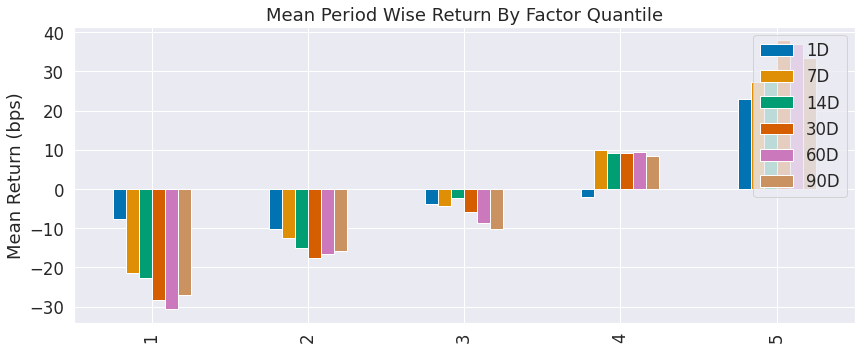

In [12]:
create_summary_tear_sheet(lr_factor_data);

In [ ]:
# The above breaks down the mean forward returns for each holding period based on the quantile of the signals
# There doesn't seem to be a single holding period that consistently performs strongly over the others by a huge amount

array([<AxesSubplot:title={'center':'7D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

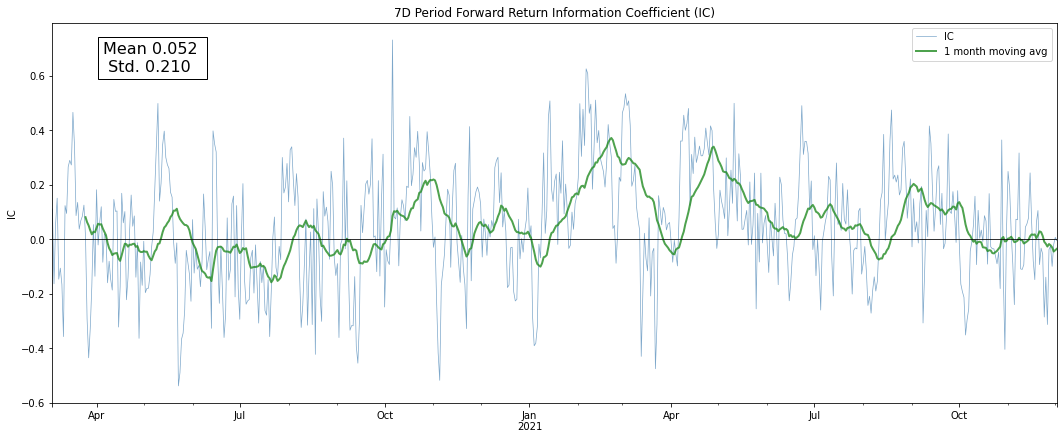

In [35]:
ic = factor_information_coefficient(lr_factor_data)
plot_ic_ts(ic[['7D']])

In [ ]:
# Information coefficient over time from scipy.stats.spearmanr
# period-wise correlation and time series plot with  with a 1 mont moving average.
# An IC over 0.05 allows for the potential of significant out performance of a benchmark

<AxesSubplot:xlabel='date'>

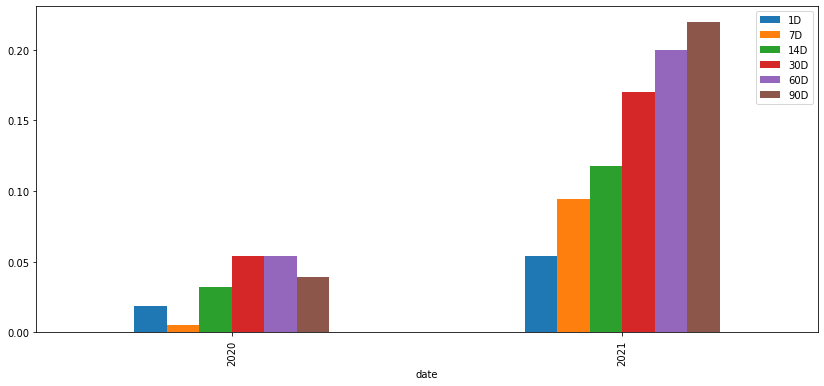

In [40]:
ic = factor_information_coefficient(lr_factor_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14,6))

In [41]:
# Above is a plot of the annual IC. An IC over 0.05 is significant enough to potentially prodice positive returns 
# compared to a benchmark.

In [13]:
# From Ridge
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [14]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

Dates                      Coin                 
2020-03-04 00:00:00+00:00  basic-attention-token    0.021344
                           binancecoin              0.018499
                           bitcoin                  0.016570
                           bitcoin-cash             0.017865
                           bitcoin-cash-sv          0.017197
dtype: float64

In [15]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 7, 14, 30, 60, 90))
ridge_factor_data.info()

Dropped 12.2% entries from factor data: 12.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24920 entries, (Timestamp('2020-03-04 00:00:00+0000', tz='UTC', freq='C'), 'basic-attention-token') to (Timestamp('2021-12-02 00:00:00+0000', tz='UTC', freq='C'), 'zcash')
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               24920 non-null  float64
 1   7D               24920 non-null  float64
 2   14D              24920 non-null  float64
 3   30D              24920 non-null  float64
 4   60D              24920 non-null  float64
 5   90D              24920 non-null  float64
 6   factor           24920 non-null  float64
 7   factor_quantile  24920 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.6+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.237539,0.068943,-0.016682,0.024337,5112,20.513644
2,-0.141594,0.084887,-0.004741,0.020184,5111,20.509631
3,-0.125731,0.091565,0.000532,0.020037,4474,17.953451
4,-0.116997,0.115162,0.005550,0.020345,5111,20.509631
5,-0.105990,0.168717,0.016033,0.022953,5112,20.513644


Returns Analysis


,1D,7D,14D,30D,60D,90D
Ann. alpha,0.341,0.543,0.455,0.295,0.082,0.062
beta,0.021,0.141,0.210,0.285,0.316,0.246
Mean Period Wise Return Top Quantile (bps),18.407,29.916,34.110,40.625,38.165,33.831
Mean Period Wise Return Bottom Quantile (bps),-8.615,-21.740,-24.617,-32.514,-31.220,-29.566
Mean Period Wise Spread (bps),27.022,50.407,57.331,71.731,51.165,27.114


Information Analysis


,1D,7D,14D,30D,60D,90D
IC Mean,0.038,0.058,0.087,0.135,0.149,0.147
IC Std.,0.212,0.218,0.216,0.237,0.241,0.257
Risk-Adjusted IC,0.178,0.266,0.404,0.568,0.619,0.571
t-stat(IC),4.490,6.721,10.224,14.362,15.645,14.424
p-value(IC),0.000,0.000,0.000,0.000,0.000,0.000
IC Skew,-0.005,-0.079,0.074,0.063,-0.002,0.149
IC Kurtosis,-0.324,-0.223,-0.331,-0.443,-0.743,-0.629


Turnover Analysis


,1D,7D,14D,30D,60D,90D
Quantile 1 Mean Turnover,0.384,0.633,0.689,0.760,0.794,0.788
Quantile 2 Mean Turnover,0.573,0.743,0.759,0.779,0.791,0.786
Quantile 3 Mean Turnover,0.655,0.773,0.781,0.803,0.796,0.809
Quantile 4 Mean Turnover,0.586,0.735,0.763,0.776,0.791,0.783
Quantile 5 Mean Turnover,0.367,0.607,0.674,0.731,0.771,0.776


,1D,7D,14D,30D,60D,90D
Mean Factor Rank Autocorrelation,0.69,0.31,0.177,0.06,0.0,0.012


<Figure size 432x288 with 0 Axes>

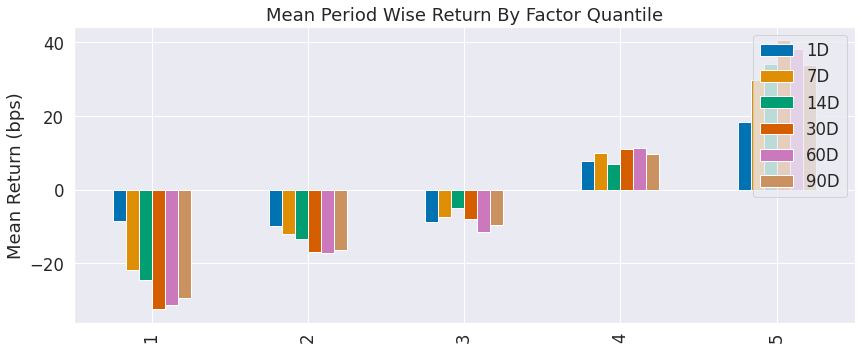

In [16]:
create_summary_tear_sheet(ridge_factor_data);

array([<AxesSubplot:title={'center':'7D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

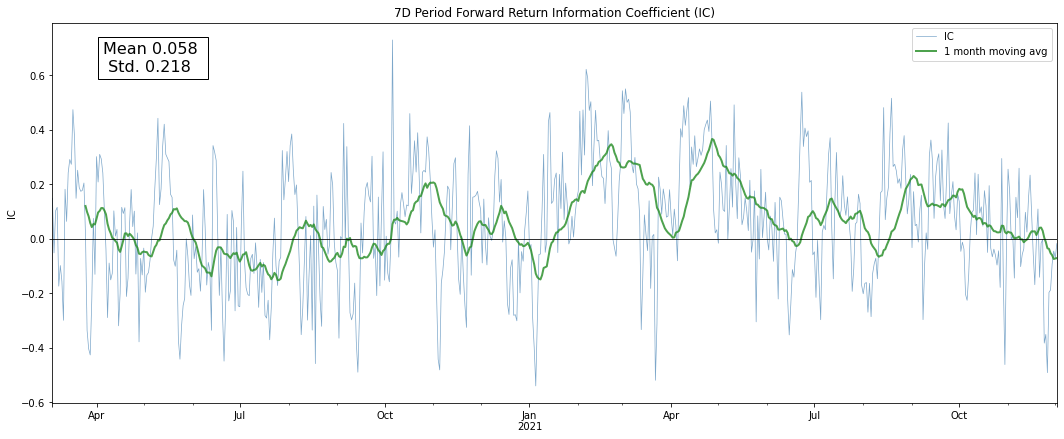

In [36]:
ic = factor_information_coefficient(ridge_factor_data)
plot_ic_ts(ic[['7D']])

<AxesSubplot:xlabel='date'>

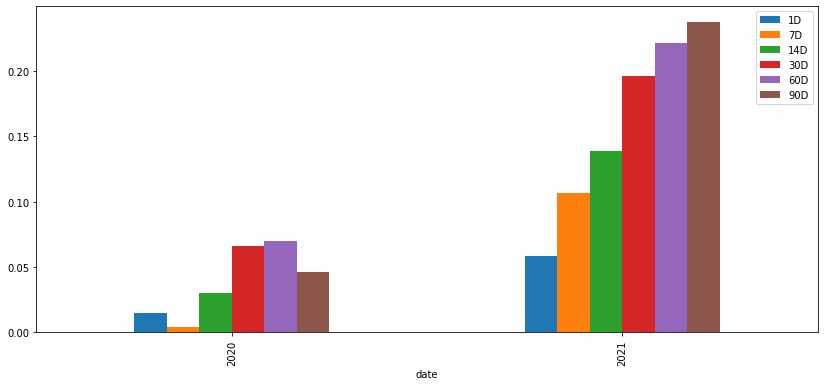

In [42]:
ic = factor_information_coefficient(ridge_factor_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14,6))

In [17]:
# From Lasso
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [18]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

Dates                      Coin                 
2020-03-04 00:00:00+00:00  basic-attention-token    0.001319
                           binancecoin              0.001319
                           bitcoin                  0.001319
                           bitcoin-cash             0.001319
                           bitcoin-cash-sv          0.001319
dtype: float64

In [21]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 7, 14, 30, 60, 90),
                                                      max_loss=50.0)
lasso_factor_data.info()

Dropped 45.2% entries from factor data: 12.2% in forward returns computation and 33.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 5000.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15560 entries, (Timestamp('2020-03-18 00:00:00+0000', tz='UTC', freq='C'), 'basic-attention-token') to (Timestamp('2021-11-30 00:00:00+0000', tz='UTC', freq='C'), 'zcash')
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               15560 non-null  float64
 1   7D               15560 non-null  float64
 2   14D              15560 non-null  float64
 3   30D              15560 non-null  float64
 4   60D              15560 non-null  float64
 5   90D              15560 non-null  float64
 6   factor           15560 non-null  float64
 7   factor_quantile  15560 non-null  float64
dtypes: float64(8)
memory usage: 1.0+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.156212,0.042850,-0.008525,0.016223,3192,20.514139
2.0,-0.088850,0.056277,-0.002871,0.011249,3191,20.507712
3.0,-0.079462,0.065007,-0.000702,0.010656,2794,17.956298
4.0,-0.071071,0.075362,0.001168,0.010679,3191,20.507712
5.0,-0.063432,0.127159,0.004521,0.012096,3192,20.514139


Returns Analysis


,1D,7D,14D,30D,60D,90D
Ann. alpha,0.671,0.779,0.759,0.544,0.252,0.070
beta,0.013,0.203,0.239,0.350,0.286,0.237
Mean Period Wise Return Top Quantile (bps),28.127,48.166,55.496,58.567,43.289,29.881
Mean Period Wise Return Bottom Quantile (bps),-6.255,-29.116,-30.645,-36.236,-28.655,-19.473
Mean Period Wise Spread (bps),34.383,75.341,85.037,105.504,55.573,23.379


Information Analysis


,1D,7D,14D,30D,60D,90D
IC Mean,0.051,0.080,0.117,0.166,0.167,0.156
IC Std.,0.218,0.225,0.230,0.278,0.300,0.310
Risk-Adjusted IC,0.236,0.358,0.511,0.597,0.557,0.504
t-stat(IC),4.705,7.143,10.207,11.935,11.130,10.074
p-value(IC),0.000,0.000,0.000,0.000,0.000,0.000
IC Skew,0.020,-0.126,-0.015,-0.049,0.109,0.264
IC Kurtosis,-0.103,-0.446,-0.598,-0.880,-0.829,-1.035


Turnover Analysis


,1D,7D,14D,30D,60D,90D
Quantile 1 Mean Turnover,0.385,0.599,0.662,0.756,0.780,0.790
Quantile 2 Mean Turnover,0.532,0.702,0.742,0.775,0.782,0.792
Quantile 3 Mean Turnover,0.584,0.759,0.777,0.803,0.811,0.812
Quantile 4 Mean Turnover,0.529,0.691,0.749,0.786,0.793,0.798
Quantile 5 Mean Turnover,0.405,0.587,0.660,0.743,0.768,0.791


,1D,7D,14D,30D,60D,90D
Mean Factor Rank Autocorrelation,0.581,0.339,0.216,0.058,0.008,-0.011


<Figure size 432x288 with 0 Axes>

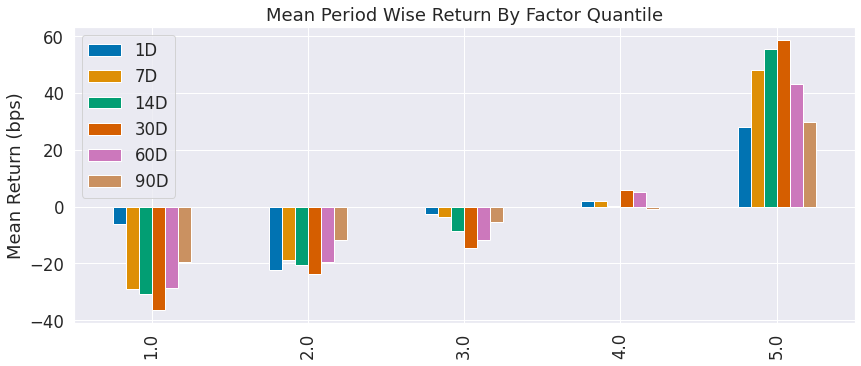

In [22]:
create_summary_tear_sheet(lasso_factor_data);

array([<AxesSubplot:title={'center':'7D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

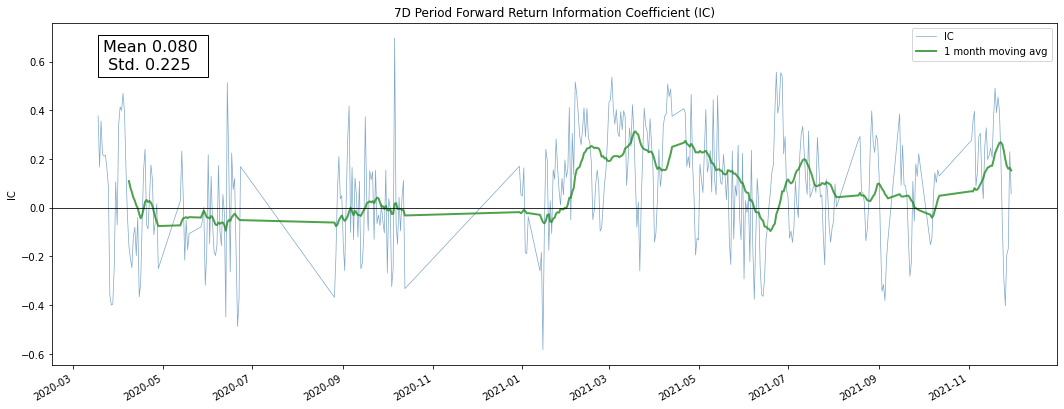

In [37]:
ic = factor_information_coefficient(lasso_factor_data)
plot_ic_ts(ic[['7D']])

<AxesSubplot:xlabel='date'>

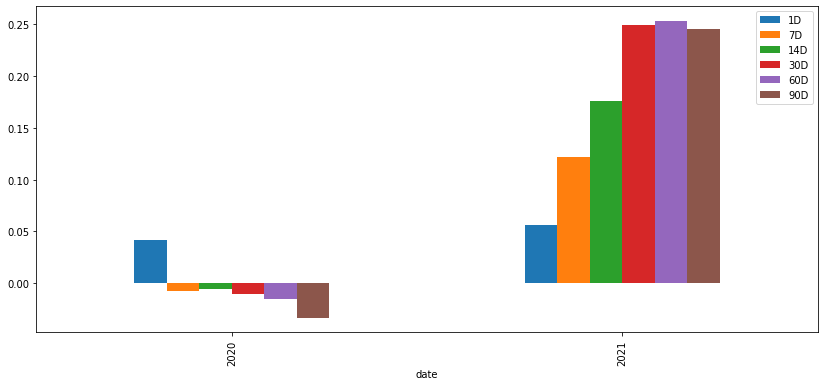

In [43]:
ic = factor_information_coefficient(lasso_factor_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14,6))